In [10]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import yaml

In [11]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

/home/philneff/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
groupby = df.groupby(['MissionYear', 'R-T', 'PULOC', 'DropLoc'])
table = groupby.size().reset_index()
flights = groupby['MissionID'].nunique().reset_index()['MissionID']
table.columns = ['year', 'R-T', 'pickup_airport', 'dropoff_airport', 'passengers']
table['flights'] = flights
table.reset_index(drop=True, inplace=True)
all_kbfi = (table['pickup_airport'] == 'KBFI') | (table['dropoff_airport'] == 'KBFI')
table.to_csv('../output/flight_summary.csv.gz', index=False, compression='gzip', encoding='utf-8', sep='|')

In [14]:
flights = pd.read_csv('../output/flight_summary.csv.gz', compression='gzip', sep='|')
# flights = pd.read_csv('../output/guatemala_transfers.csv.gz', compression='gzip', sep='|')

In [15]:
flights.head()

,year,R-T,pickup_airport,dropoff_airport,passengers,flights
0,2010,R,KAEX,KHRL,2025,23
1,2010,R,KAEX,KLRD,27,2
2,2010,R,KAEX,MDSD,549,6
3,2010,R,KAEX,MGGT,1441,13
4,2010,R,KAEX,MHLM,454,5


In [19]:
flights['pickup_airport'] = flights['pickup_airport'].str.upper()
flights['dropoff_airport'] = flights['dropoff_airport'].str.upper()
# flights['pickup_airport'] = flights['PULOC'].str.upper()
# flights['dropoff_airport'] = flights['DropLoc'].str.upper()

In [20]:
flights_loc = set(pd.concat([flights['pickup_airport'], flights['dropoff_airport']]))

In [21]:
bad_airports = ['KKBL']

In [22]:
flights = flights[~flights['pickup_airport'].isin(bad_airports)]
flights = flights[~flights['dropoff_airport'].isin(bad_airports)]

In [23]:
airports = pd.read_csv('../../share/hand/GlobalAirportDatabase.csv.gz', compression='gzip', sep='|')

In [24]:
airports.head()

,ICAOCode,IATACode,AirportName,City,Country,LatitudeDegrees,LatitudeMinutes,LatitudeSeconds,LatitudeDirection,LongitudeDegrees,LongitudeMinutes,LongitudeSeconds,LongitudeDirection,Altitude,LatitudeDecimalDegrees,LongitudeDecimalDegrees
0,AYGA,GKA,GOROKA,GOROKA,PAPUA NEW GUINEA,6,4,54,S,145,23,30,E,1610,-6.082,145.392
1,AYLA,LAE,NaN,LAE,PAPUA NEW GUINEA,0,0,0,U,0,0,0,U,0,0.000,0.000
2,AYMD,MAG,MADANG,MADANG,PAPUA NEW GUINEA,5,12,25,S,145,47,19,E,7,-5.207,145.789
3,AYMH,HGU,MOUNT HAGEN,MOUNT HAGEN,PAPUA NEW GUINEA,5,49,34,S,144,17,46,E,1643,-5.826,144.296
4,AYNZ,LAE,NADZAB,NADZAB,PAPUA NEW GUINEA,6,34,11,S,146,43,34,E,73,-6.570,146.726


In [25]:
airports_loc = set(airports['ICAOCode'])

In [26]:
airports.set_index('ICAOCode', inplace=True)

In [27]:
additional_airports = pd.read_csv('../../share/hand/locations.csv', quotechar='"')

In [28]:
additional_airports.columns = ['ICAOCode', 'CountryISO', 'State', 'City', 'LatitudeDecimalDegrees', 'LongitudeDecimalDegrees']
additional_airports.set_index('ICAOCode', inplace=True)
additional_airports.head()

,CountryISO,State,City,LatitudeDecimalDegrees,LongitudeDecimalDegrees
ICAOCode,,,,,
BKPR,KS,Pristina,Slatina,42.572778,21.035833
EYVI,LT,Vilnius,Vilnius,54.636944,25.287778
FKYS,CM,Nsimalen,Nsimalen,3.722500,11.553333
FYWH,NaN,Windhoek,Windhoek,-22.486667,17.462500
GQNO,MR,Nouakchott,Nouakchott,18.310000,-15.969722


In [29]:
missing_airports = list(flights_loc.difference(airports_loc))

In [30]:
missing_airports

['KIWA',
 'OYSN',
 'SYCJ',
 'RJBB',
 'VGHS',
 'FYWH',
 'KPSM',
 'OMDW',
 'ORBI',
 'BKPR',
 'TXKF',
 'KRFD',
 'KYKM',
 'HKJK',
 'UGTB',
 'KMWA',
 'FKYS',
 'KSDM',
 'GUCY',
 'KLAW',
 'KGYY',
 'SPJC',
 'KNYL',
 'KTWF',
 'GQNO',
 'KCSG',
 'SAEZ',
 'KKBL',
 'MHSC',
 'GVNP',
 'KTOL',
 'EYVI']

In [31]:
airports_2 = additional_airports[additional_airports.index.isin(missing_airports)].copy()

In [32]:
airports_2.head()

,CountryISO,State,City,LatitudeDecimalDegrees,LongitudeDecimalDegrees
ICAOCode,,,,,
BKPR,KS,Pristina,Slatina,42.572778,21.035833
EYVI,LT,Vilnius,Vilnius,54.636944,25.287778
FKYS,CM,Nsimalen,Nsimalen,3.722500,11.553333
FYWH,NaN,Windhoek,Windhoek,-22.486667,17.462500
GQNO,MR,Nouakchott,Nouakchott,18.310000,-15.969722


In [33]:
airports_2 = airports_2[['LatitudeDecimalDegrees', 'LongitudeDecimalDegrees']]

In [34]:
airports = pd.concat([airports, airports_2])

/home/philneff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [35]:
airports

,AirportName,Altitude,City,Country,IATACode,LatitudeDecimalDegrees,LatitudeDegrees,LatitudeDirection,LatitudeMinutes,LatitudeSeconds,LongitudeDecimalDegrees,LongitudeDegrees,LongitudeDirection,LongitudeMinutes,LongitudeSeconds
ICAOCode,,,,,,,,,,,,,,,
AYGA,GOROKA,1610.0,GOROKA,PAPUA NEW GUINEA,GKA,-6.082000,6.0,S,4.0,54.0,145.392000,145.0,E,23.0,30.0
AYLA,NaN,0.0,LAE,PAPUA NEW GUINEA,LAE,0.000000,0.0,U,0.0,0.0,0.000000,0.0,U,0.0,0.0
AYMD,MADANG,7.0,MADANG,PAPUA NEW GUINEA,MAG,-5.207000,5.0,S,12.0,25.0,145.789000,145.0,E,47.0,19.0
AYMH,MOUNT HAGEN,1643.0,MOUNT HAGEN,PAPUA NEW GUINEA,HGU,-5.826000,5.0,S,49.0,34.0,144.296000,144.0,E,17.0,46.0
AYNZ,NADZAB,73.0,NADZAB,PAPUA NEW GUINEA,LAE,-6.570000,6.0,S,34.0,11.0,146.726000,146.0,E,43.0,34.0
AYPY,PORT MORESBY JACKSONS INTERNATIONAL,45.0,PORT MORESBY,PAPUA NEW GUINEA,POM,-9.443000,9.0,S,26.0,36.0,147.220000,147.0,E,13.0,12.0
AYRB,NaN,0.0,RABAUL,PAPUA NEW GUINEA,RAB,0.000000,0.0,U,0.0,0.0,0.000000,0.0,U,0.0,0.0
AYWK,WEWAK INTERNATIONAL,6.0,WEWAK,PAPUA NEW GUINEA,WWK,-3.584000,3.0,S,35.0,1.0,143.669000,143.0,E,40.0,9.0
BGAM,NaN,0.0,ANGMAGSSALIK,GREENLAND,NaN,0.000000,0.0,U,0.0,0.0,0.000000,0.0,U,0.0,0.0


In [36]:
edges = flights[['pickup_airport', 'dropoff_airport']].values

In [37]:
g = nx.from_edgelist(edges)

In [38]:
len(g.nodes()), len(g.edges())

(222, 722)

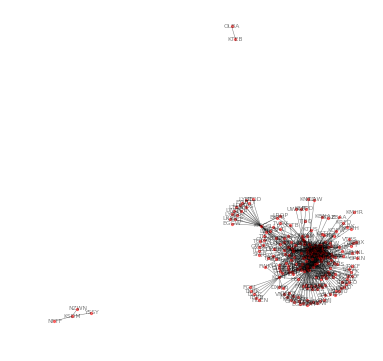

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(g, ax=ax, node_size=5,
                 font_size=6, alpha=.5,
                 width=.5)
ax.set_axis_off()

In [40]:
sg = next(nx.connected_component_subgraphs(g))

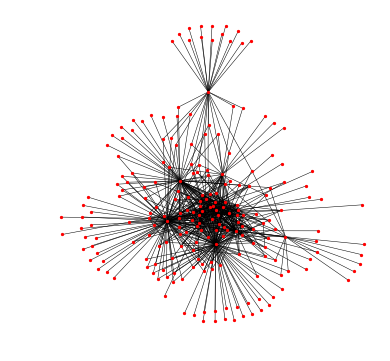

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(sg, ax=ax, with_labels=False,
                 node_size=5, width=.5)
ax.set_axis_off()

In [42]:
pos = {airport: (v['LongitudeDecimalDegrees'], v['LatitudeDecimalDegrees'])
       for airport, v in
       airports.to_dict('index').items()}

In [43]:
pos

{'AYGA': (145.392, -6.082000000000001),
 'AYLA': (0.0, 0.0),
 'AYMD': (145.789, -5.207000000000001),
 'AYMH': (144.296, -5.8260000000000005),
 'AYNZ': (146.726, -6.57),
 'AYPY': (147.22, -9.443),
 'AYRB': (0.0, 0.0),
 'AYWK': (143.66899999999998, -3.5839999999999996),
 'BGAM': (0.0, 0.0),
 'BGAS': (0.0, 0.0),
 'BGAT': (0.0, 0.0),
 'BGBW': (-45.427, 61.161),
 'BGCH': (0.0, 0.0),
 'BGCO': (-22.646, 70.73899999999999),
 'BGDB': (0.0, 0.0),
 'BGDH': (0.0, 0.0),
 'BGDU': (0.0, 0.0),
 'BGEM': (0.0, 0.0),
 'BGFD': (0.0, 0.0),
 'BGFH': (0.0, 0.0),
 'BGGD': (0.0, 0.0),
 'BGGH': (-51.678000000000004, 64.191),
 'BGGN': (0.0, 0.0),
 'BGHB': (0.0, 0.0),
 'BGIS': (0.0, 0.0),
 'BGIT': (0.0, 0.0),
 'BGJH': (0.0, 0.0),
 'BGJN': (-51.067, 69.233),
 'BGKD': (0.0, 0.0),
 'BGKK': (-37.15, 65.583),
 'BGKM': (0.0, 0.0),
 'BGKT': (0.0, 0.0),
 'BGMV': (0.0, 0.0),
 'BGNN': (0.0, 0.0),
 'BGNS': (0.0, 0.0),
 'BGOS': (0.0, 0.0),
 'BGPC': (0.0, 0.0),
 'BGRS': (0.0, 0.0),
 'BGSC': (0.0, 0.0),
 'BGSF': (-50.688999999

In [44]:
deg = nx.degree(sg)
sizes = [5 * deg[icao] for icao in sg.nodes]

In [45]:
# altitude = airports_us['alt']
# altitude = [altitude[icao] for icao in sg.nodes]

In [46]:
labels = {icao: icao if deg[icao] >= 20 else ''
          for icao in sg.nodes}

/home/philneff/anaconda3/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


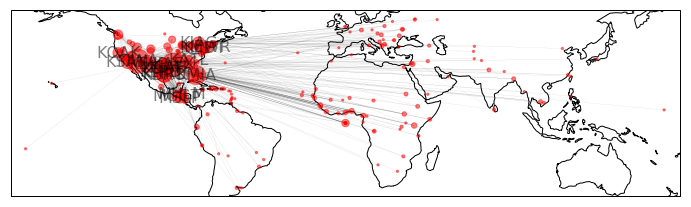

In [47]:
# Map projection
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
ax.coastlines()
# Extent of continental US.
# ax.set_extent([-128, -62, 10, 50])
nx.draw_networkx(sg, ax=ax,
                 font_size=16,
                 alpha=.5,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.autumn)